In [2]:
import glob
import scipy.stats
import numpy as np
import pickle
import os

from itertools import combinations
from scipy import spatial
from metrics import rsa
from data import one_hot
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
# find which keys are available
file = glob.glob("runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2/*/*.pkl")[0]
file = pickle.load(open(file, 'rb'))
keys = file.keys()
print(keys)

dict_keys(['loss', 'acc', 'entropy', 'messages', 'h_sender', 'h_rnn_sender', 'h_receiver', 'h_rnn_receiver', 'targets', 'distractors', 'RSA:h_sender/h_rnn_sender', 'RSA:h_sender/h_receiver', 'RSA:h_sender/h_rnn_receiver', 'RSA:h_sender/targets', 'RSA:h_sender/messages', 'RSA:h_rnn_sender/h_receiver', 'RSA:h_rnn_sender/h_rnn_receiver', 'RSA:h_rnn_sender/targets', 'RSA:h_rnn_sender/messages', 'RSA:h_receiver/h_rnn_receiver', 'RSA:h_receiver/targets', 'RSA:h_receiver/messages', 'RSA:h_rnn_receiver/targets', 'RSA:h_rnn_receiver/messages', 'RSA:targets/messages'])


In [23]:
def plot_metric(paths, metric="loss", run='baseline', ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    results = {}
    for path in paths:
        results[path] = {}
        for m in glob.glob(path + "/*/*.pkl"):

            seed = m.split('/')[2]
            if seed not in results[path]:
                results[path][seed] = {}

            it = m.split('_')[-1].split('.')[0]

            if it == 'metrics':
                continue
                
            iteration = int(it)
            results[path][seed][iteration] = pickle.load(open(m, 'rb'))
        
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    generations = []
    values = []
    run_names = []
    
    for r in list(results.keys()):
        for s in list(results[r].keys()):    
            for g in sorted(list(results[r][s].keys())):
                generations.append(g)
                values.append(results[r][s][g][metric])
                
                if 'related' not in r:
                    run_names.append('Baseline')
                else:
                    run_names.append('Strict environment')

    values = np.array(values)
    iterations = np.array(generations)   
    
    # voeg hier metrics toe
    d = {'Iterations': iterations, 'Run': run_names, metric: values}

    ax = sns.lineplot(ax=ax, x='Iterations', y=metric, hue='Run', data=pd.DataFrame(data=d))

    #if title is None:
    #    title = metric.replace('_', ' ').title()
        
    ax.set_ylabel('RSA')
    ax.set_title(title, fontsize=30)
    plt.show()
    
def plot_all_metric(results, metric="loss", runs="all", ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
        
    run_names = []
    all_values = []
    all_iterations = []
    
    for r in list(results.keys()):
        # check which run the user would like to see
        if r == runs or runs=="all":
            values = []
            generations = []
            for s in list(results[r].keys()):    
                for g in sorted(list(results[r][s].keys())):
                    generations.append(g)
                    values.append(results[r][s][g][metric])
                    #run_names.append(r)

            values = np.array(values)
            iterations = np.array(generations) 
            all_values.append(values)
            all_iterations.append(iterations)

    # initialize data dictionary
    d = {}
    
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        if key == runs or runs=="all":
            d[key] = all_values[i]  
            d['Iterations'] = all_iterations[i]
    data_preproc=pd.DataFrame(data=d)

    # plot data
    ax = sns.lineplot(x='Iterations', y=metric, hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name=metric))
    
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()


# Standard Indicators

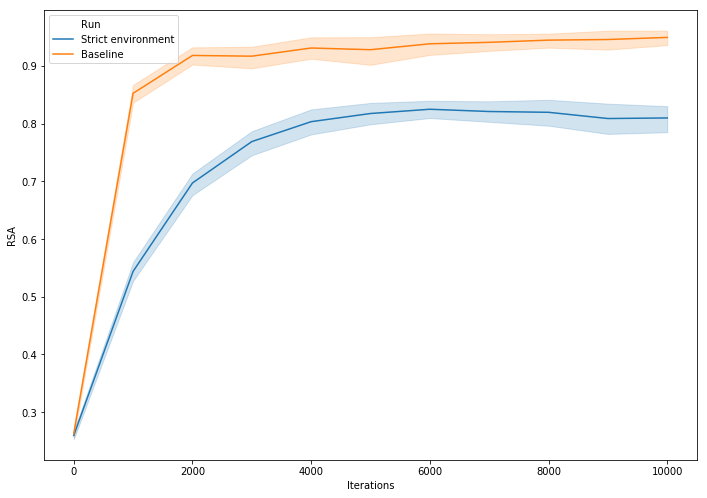

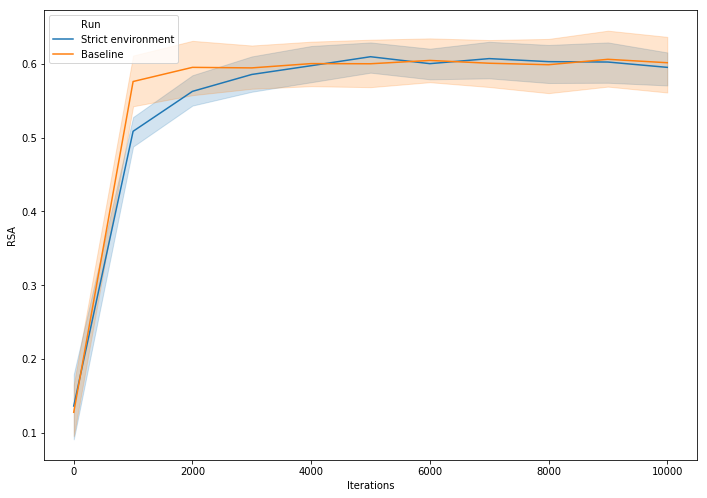

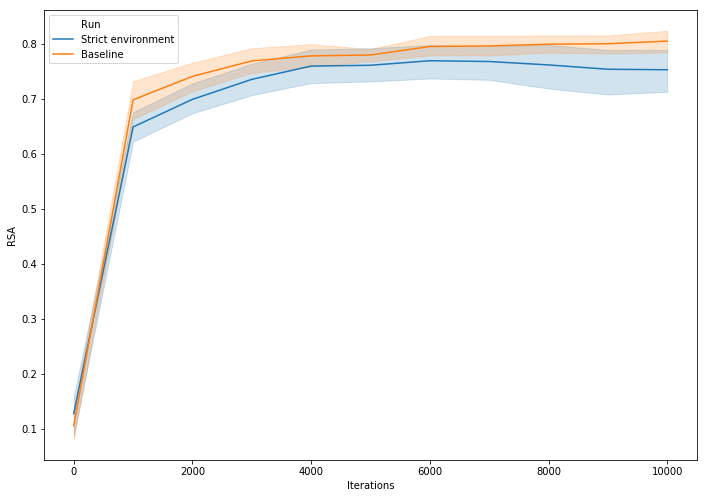

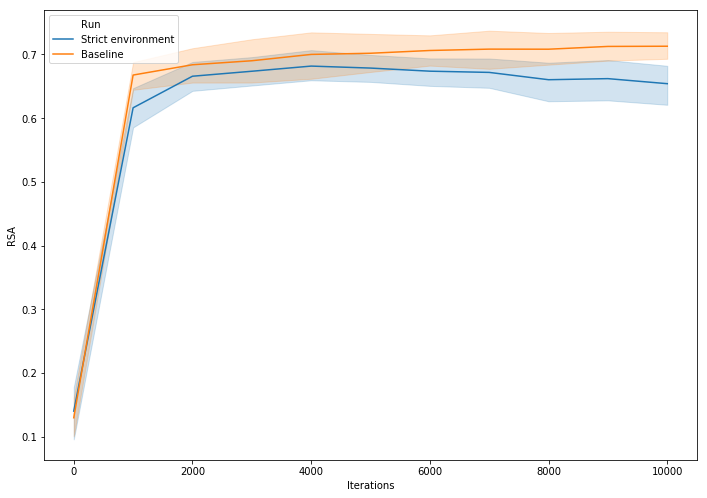

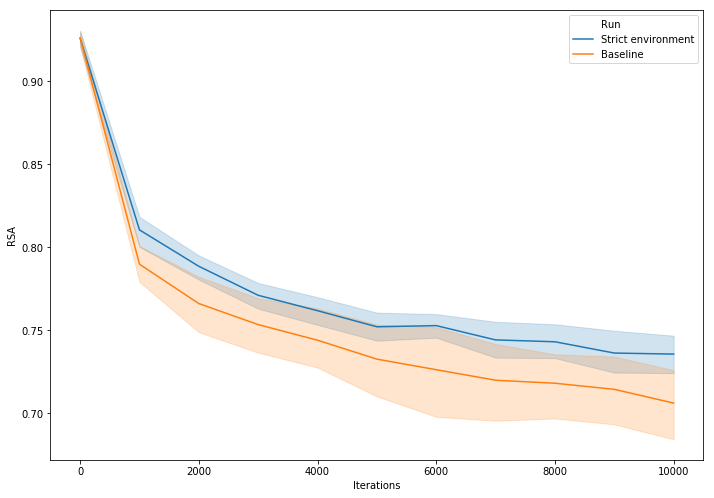

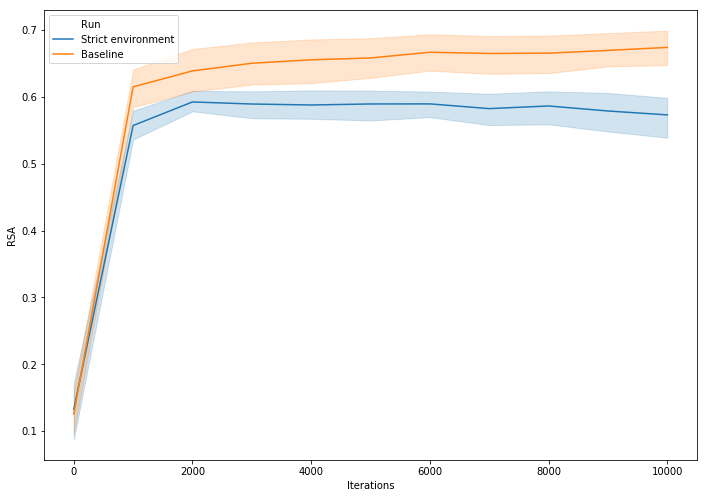

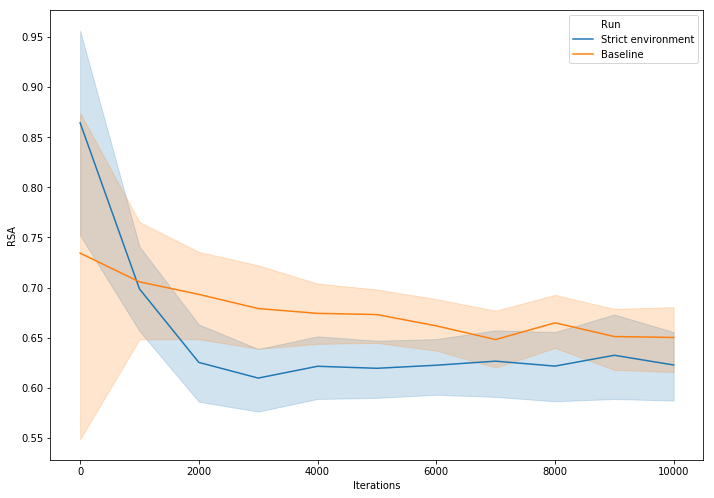

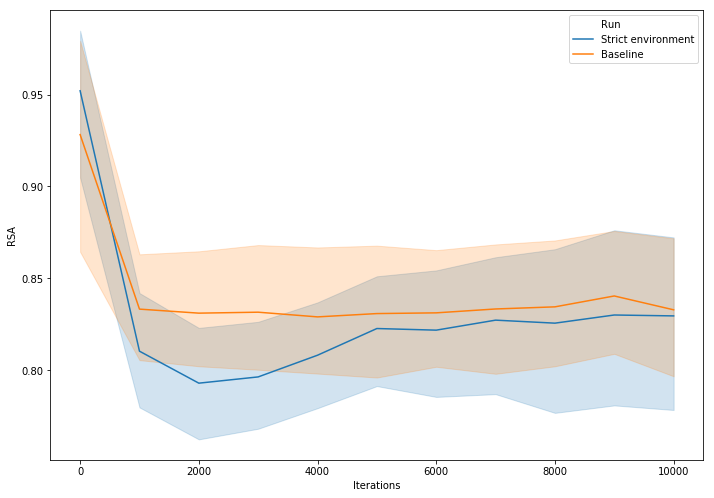

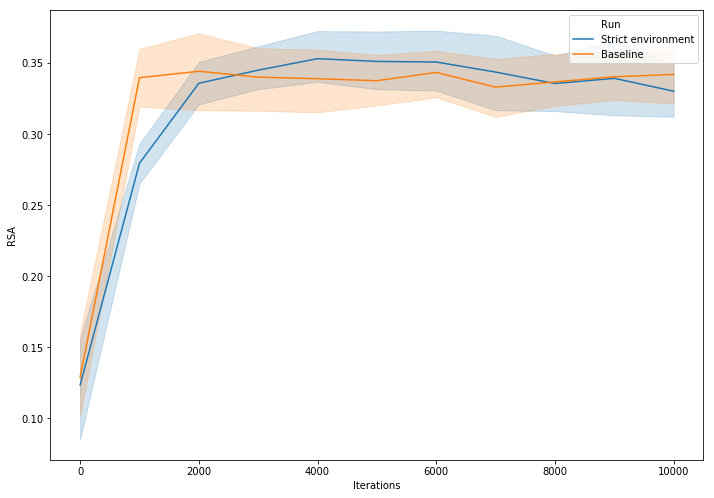

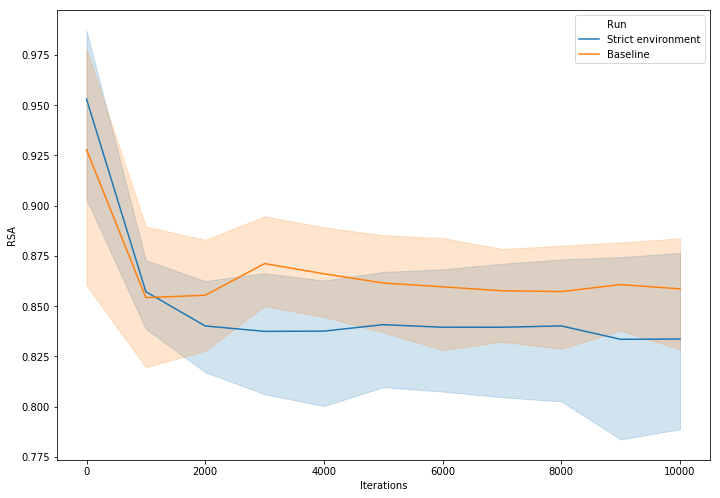

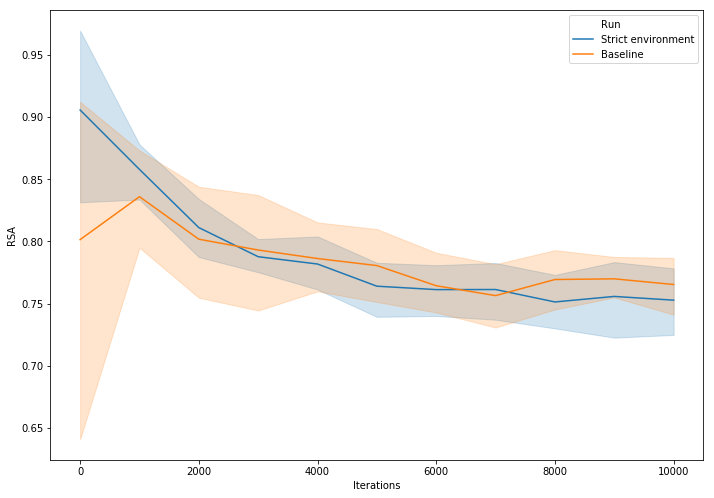

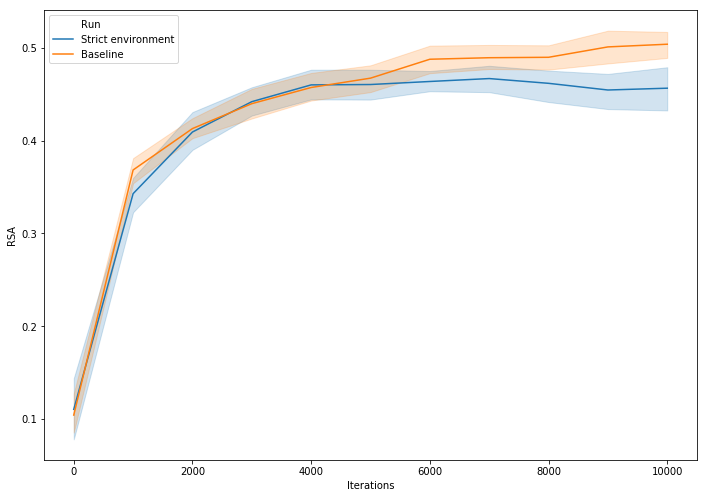

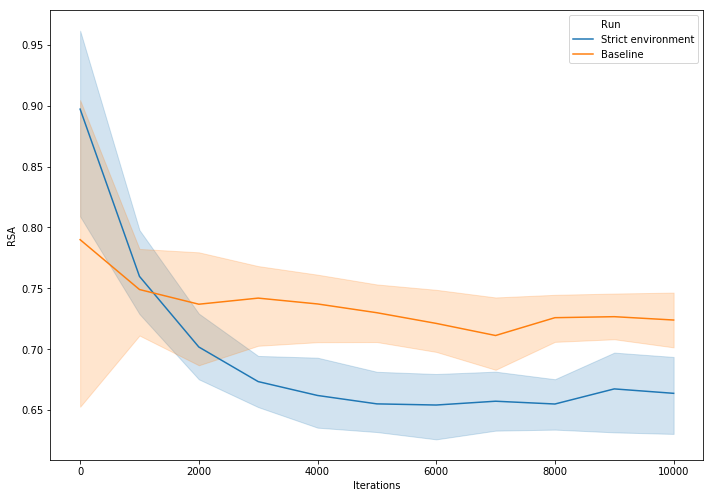

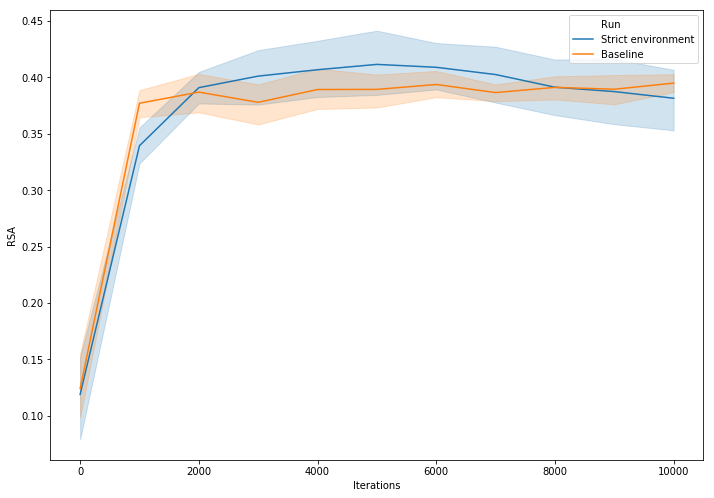

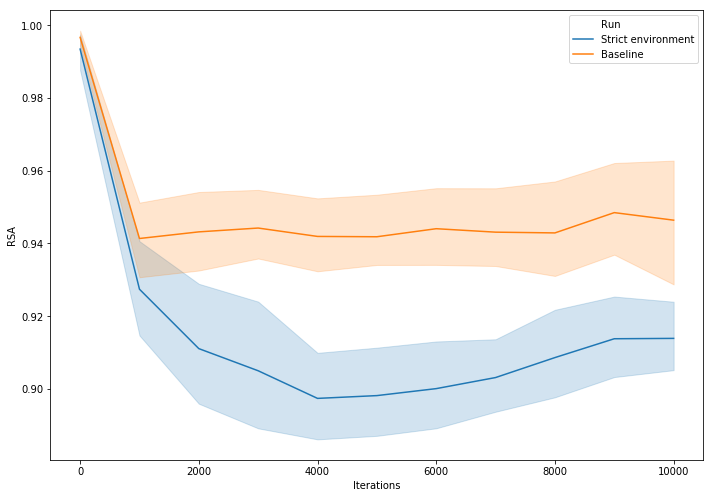

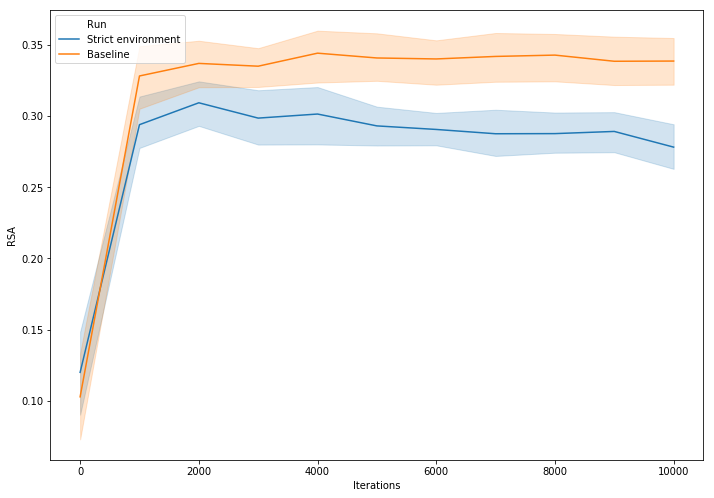

In [24]:
# RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2/rsa_analysis.pkl', 'rb'))

# RSA_ANALYSIS = {
#                 'Baseline' : RSA_BASELINE,                
#                }

paths = ["runs/lstm_max_len_5_vocab_5_same_data_attr_4_related_split_2",
        "runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2"]

for k in keys:
    if 'RSA' in k or 'acc' in k:
        plot_metric(paths, metric=k)


# Standard RSA Metrics 

Variables:
- H_Sender: The hidden state after passing input through linear layer (this hidden state initializes the RNN)
- H_RNN_Sender: The hidden states output that generated each word in the message
- H_RNN_receiver: The hidden states output after passing over each word in message
- H_Receiver: The hidden state outputed by the final output layer (this is used to calculate Score w.r.t. original input)
- Targets: Target/Input vectors for instance (1 0 0 1 0 0 1 0 1 0 0 1 0 0) 
- Messages: Discrete Messages generated by sender

Distances used:
- "h_sender": spatial.distance.cosine
- "h_rnn_sender": flatten_cos #flatten sequence and run cosine distance
- "h_receiver": spatial.distance.cosine
- "h_rnn_receiver": flatten_cos #flatten sequence and run cosine distance
- "targets": spatial.distance.hamming 
- "messages": on_hot_hamming #one hot sequence, flatten and then run hamming distance


In [ ]:
for k in metrics['baseline']['10'][0]:
    if 'RSA' in k:
        plot_metric(metrics, metric=k)

# Cross Seed RSA

In [ ]:

def plot_rsa_metric(results, metric, ylabel=None, show_error=True, 
                    savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    # initialize plots
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    # get data to fill up plot
    all_values = []
    for result in results.values():

        generations = []
        values = []
        run_names = []

        for s in list(result[metric].keys()):    
            for g in sorted(list(result[metric][s].keys())):
                generations.append(g)
                values.append(result[metric][s][g])
                run_names.append(metric)

        values = np.array(values)
        iterations = np.array(generations)   
        all_values.append(values)
    

    # initialize data dictionary
    d = {'Iterations': iterations}
    
    # fill dictionary with rest of data
    for i, key in enumerate(results.keys()):
        d[key] = all_values[i]    
    data_preproc=pd.DataFrame(data=d)
    #print(pd.melt(data_preproc, ['Iterations']))

    ax = sns.lineplot(x='Iterations', y="RSA", hue='method', 
                      data=pd.melt(data_preproc, ['Iterations'],
                                   var_name='method',
                                   value_name="RSA"))

    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()

# Vocab 25, max length 10

In [ ]:
RSA_BASELINE = pickle.load(open(f'{baseline_path}/rsa_analysis.pkl', 'rb'))
RSA_SAME_DATA = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_same_data_attr_5/rsa_analysis.pkl', 'rb'))
RSA_4_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_4/rsa_analysis.pkl', 'rb'))
RSA_3_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_3/rsa_analysis.pkl', 'rb'))
RSA_2_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_2/rsa_analysis.pkl', 'rb'))
#RSA_1_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_1/rsa_analysis.pkl', 'rb'))
 

RSA_ANALYSIS = {'baseline': RSA_BASELINE,
                'Same data': RSA_SAME_DATA,
                '4 attributes': RSA_4_ATTR,
                '3 attributes': RSA_3_ATTR,
                '2 attributes': RSA_2_ATTR,
               }

for k in RSA_BASELINE:
    plot_rsa_metric(RSA_ANALYSIS, metric=k)

# Vocab 5, max length 5

In [ ]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_5_attr_5/rsa_analysis.pkl', 'rb'))
#RSA_SAME_DATA = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_same_data_attr_5/rsa_analysis.pkl', 'rb'))
RSA_4_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_5_attr_4/rsa_analysis.pkl', 'rb'))
RSA_3_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_5_attr_3/rsa_analysis.pkl', 'rb'))
RSA_2_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_5_attr_2/rsa_analysis.pkl', 'rb'))
#RSA_1_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_1/rsa_analysis.pkl', 'rb'))
 

RSA_ANALYSIS = {'baseline': RSA_BASELINE,
                #'Same data': RSA_SAME_DATA,
                '4 attributes': RSA_4_ATTR,
                '3 attributes': RSA_3_ATTR,
                '2 attributes': RSA_2_ATTR,
               }

for k in RSA_BASELINE:
    plot_rsa_metric(RSA_ANALYSIS, metric=k)

# Vocab 3, max length 5

In [ ]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_3_attr_5/rsa_analysis.pkl', 'rb'))
#RSA_SAME_DATA = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_same_data_attr_5/rsa_analysis.pkl', 'rb'))
RSA_4_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_3_attr_4/rsa_analysis.pkl', 'rb'))
RSA_3_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_3_attr_3/rsa_analysis.pkl', 'rb'))
RSA_2_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_3_attr_2/rsa_analysis.pkl', 'rb'))
#RSA_1_ATTR = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_1/rsa_analysis.pkl', 'rb'))
 

RSA_ANALYSIS = {'baseline': RSA_BASELINE,
                #'Same data': RSA_SAME_DATA,
                '4 attributes': RSA_4_ATTR,
                '3 attributes': RSA_3_ATTR,
                '2 attributes': RSA_2_ATTR,
               }

for k in RSA_BASELINE:
    plot_rsa_metric(RSA_ANALYSIS, metric=k)

# Overview pressure analysis

In [ ]:
RSA_0 = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_0_attr_5/rsa_analysis.pkl', 'rb'))
RSA_1 = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_1_attr_5/rsa_analysis.pkl', 'rb'))
RSA_2 = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_3_attr_5/rsa_analysis.pkl', 'rb'))
RSA_3 = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_5_vocab_5_attr_5/rsa_analysis.pkl', 'rb'))
RSA_4 = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_attr_5/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'0 vocab, 5 max-len': RSA_0,
                '1 vocab, 5 max-len': RSA_1,
                '3 vocab, 5 max-len': RSA_2,
                '5 vocab, 5 max-len': RSA_3,
                '25 vocab, 10 max-len': RSA_4,
               }

for k in RSA_BASELINE:
    plot_rsa_metric(RSA_ANALYSIS, metric=k)

## Performance

### Vocab size bug?

In [ ]:
perf_measures = ['lstm_h_64_lr_0.001_max_len_5_vocab_0_attr_5',
                 'lstm_h_64_lr_0.001_max_len_5_vocab_1_attr_5',
                 'lstm_h_64_lr_0.001_max_len_5_vocab_3_attr_5',
                 'lstm_h_64_lr_0.001_max_len_5_vocab_5_attr_5']

# empty dict that will recreate a smaller version of metrics
perf_metrics = {}

for key in metrics.keys():
    if key in perf_measures:
        perf_metrics[key] = metrics[key]
        
plot_all_metric(perf_metrics, 'acc')

# Task difficulty

In [ ]:
RSA_0 = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_distract_3_attr_5/rsa_analysis.pkl', 'rb'))
#RSA_SAME_DATA = pickle.load(open(f'runs/lstm_h_64_lr_0.001_max_len_10_vocab_25_same_data_attr_5/rsa_analysis.pkl', 'rb'))
RSA_1 = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_distract_7_attr_5/rsa_analysis.pkl', 'rb'))
RSA_2 = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_distract_11_attr_5/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {'3 distractors': RSA_0,
                #'Same data': RSA_SAME_DATA,
                '7 distractors': RSA_1,
                '11 distractors': RSA_2,
               }
    
for k in RSA_BASELINE:
    plot_rsa_metric(RSA_ANALYSIS, metric=k)

# Performance

In [ ]:
perf_measures = ['lstm_max_len_5_vocab_5_distract_3_attr_5',
                 'lstm_max_len_5_vocab_5_distract_7_attr_5',
                 'lstm_max_len_5_vocab_5_distract_11_attr_5']

# empty dict that will recreate a smaller version of metrics
perf_metrics = {}

for key in metrics.keys():
    if key in perf_measures:
        perf_metrics[key] = metrics[key]
        
plot_all_metric(perf_metrics, 'acc')

# Related distractors
(stricter environment)

In [7]:
RSA_BASELINE = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_same_data_attr_4_split_2/rsa_analysis.pkl', 'rb'))

RSA_HARD = pickle.load(open(f'runs/lstm_max_len_5_vocab_5_same_data_attr_4_related_split_2/rsa_analysis.pkl', 'rb'))

RSA_ANALYSIS = {
                'Related distractors': RSA_HARD,
                'Baseline' : RSA_BASELINE,                
               }

for k in RSA_HARD:
    print(k)
    continue
    if k == "RSA:":
        plot_metric(RSA_ANALYSIS, metric=k)
        

h_sender
h_rnn_sender
h_receiver
h_rnn_receiver
ham_messages
lev_messages
